# Vehicles Tracking and Counting

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jun 18 21:05:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 538.18                 Driver Version: 538.18       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX130         WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0              N/A /  14W |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

e:\


## Download video

In [3]:
!pip install -q gdown
%cd {HOME}
!gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

e:\



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\hpc\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id='1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

but Gdown can't. Please check connections and permissions.


In [4]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

## Install YOLOv8

In [5]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

## Install Roboflow Supervision

In [ ]:
!pip install supervision

display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.21.0


## Load pre-trained YOLOv8 model

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 246MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

In [ ]:
import supervision as sv
import numpy as np

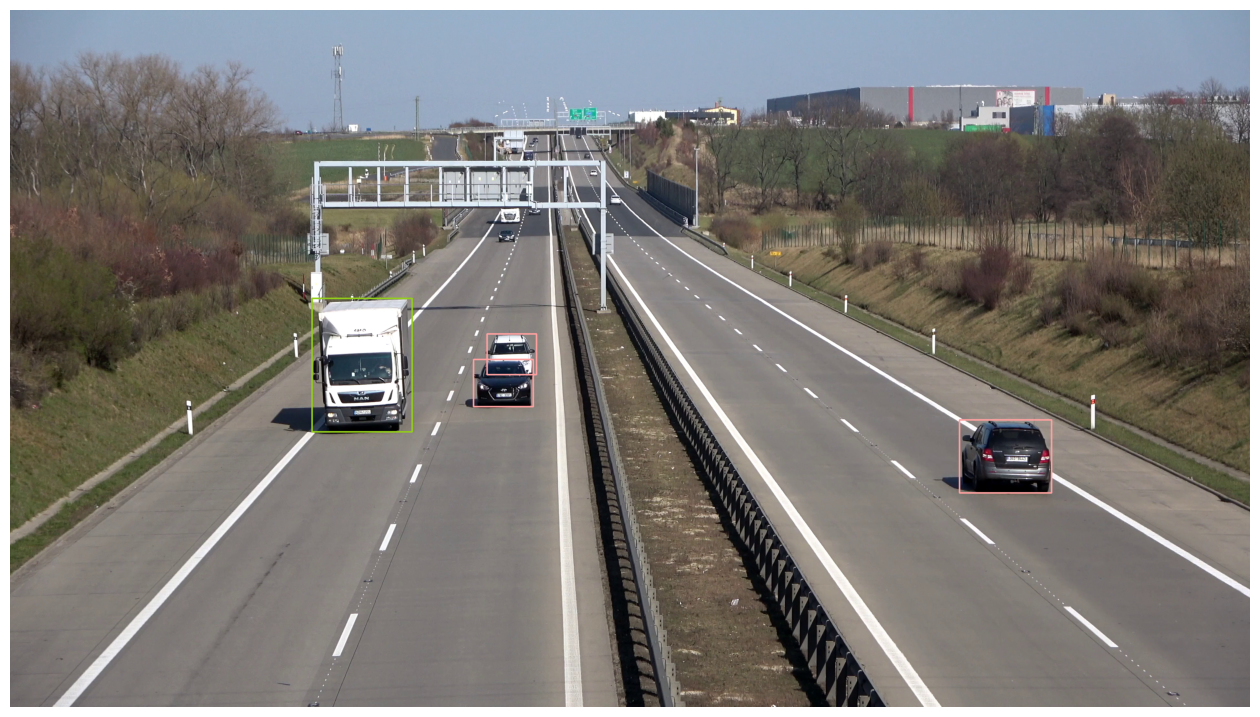

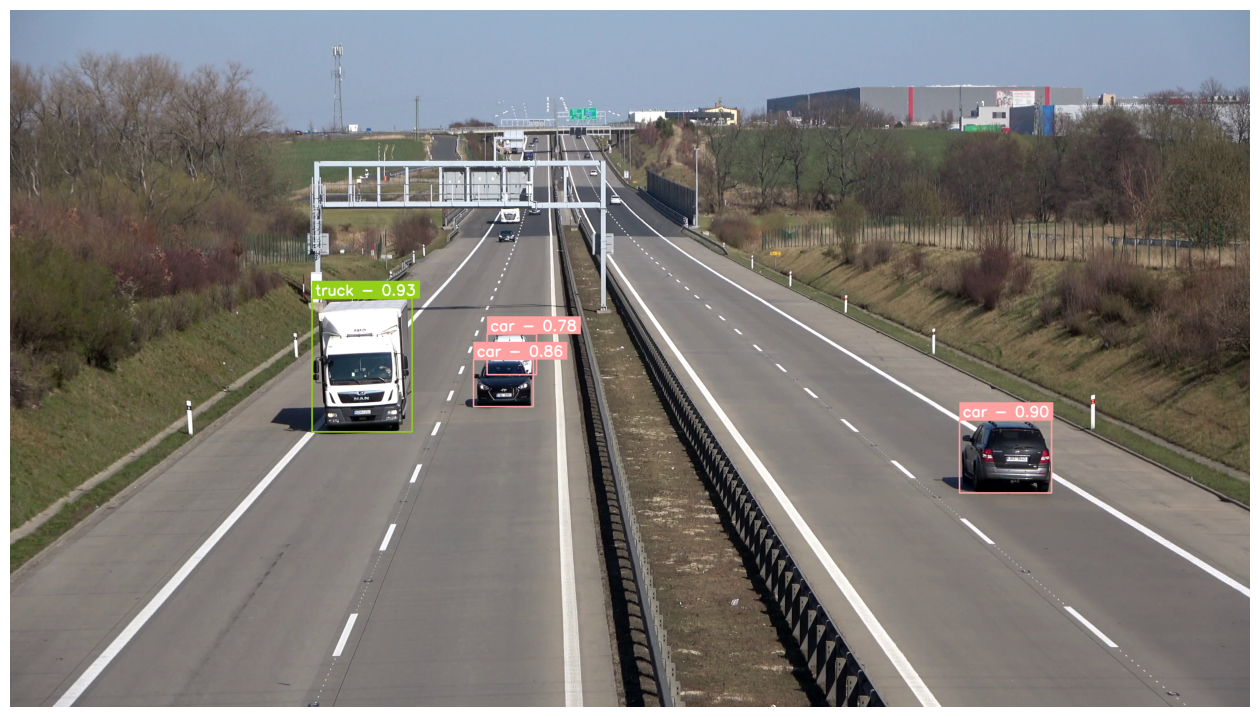

In [ ]:
%matplotlib inline
# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create instances of BoundingBoxAnnotator and LabelAnnotator
bbox_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=3, text_scale=1.5)

# Acquire the first video frame
iterator = iter(generator)
frame = next(iterator)

# Model prediction on a single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# Convert to Detections
detections = sv.Detections.from_ultralytics(results)
# Only consider class id from selected_classes
detections = detections[np.isin(detections.class_id, selected_classes)]

# Annotate bounding boxes
annotated_frame = bbox_annotator.annotate(scene=frame, detections=detections)
sv.plot_image(annotated_frame, (16, 16))

# Format custom labels and annotate
labels = [
    f"{CLASS_NAMES_DICT[class_id]} - {confidence:.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# Display the annotated frame
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

In [ ]:
# Create a BYTETracker instance with specified parameters
byte_tracker = sv.ByteTrack()

# byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)
byte_tracker.reset()

# Generate frames from the video
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create a LineZone instance, previously known as LineCounter
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Initialize annotators for bounding boxes and labels with specified styles
bbox_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

# Create a TraceAnnotator to visualize movement trajectories
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create a LineZoneAnnotator for annotating interactions with the line
line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2)

def progress_bar(index : int) -> None:
    if index == 0:
        print('Progress Bar: \n[', end='')
    if (index + 1) % 100 == 0:
        print("]\n[", end='')
    else:
        print('-', end='')


def callback(frame: np.ndarray, index: int) -> np.ndarray:
    """
    Process a single video frame to detect and track objects, and annotate the frame.

    Args:
        frame (np.ndarray): The current video frame as a numpy array.
        index (int): The index of the current frame in the video.

    Returns:
        np.ndarray: The annotated frame.
    """
    # Perform object detection on the frame
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Filter detections to include only selected classes
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Update tracks with new detections
    detections = byte_tracker.update_with_detections(detections)

    # Format labels for annotations
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence,
                                                    detections.class_id,
                                                    detections.tracker_id)
    ]

    # Annotate frame with traces of tracked objects
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections)

    # Annotate frame with bounding boxes
    annotated_frame = bbox_annotator.annotate(
        scene=annotated_frame,
        detections=detections)

    # Further annotate with labels
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # Update the line counter with the current detections
    line_zone.trigger(detections)

    # Progress Bar
    progress_bar(index)

    # Annotate and return the frame with line interactions
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the entire video and apply the callback function to each frame
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

WARNING ⚠️ NMS time limit 2.050s exceeded
Progress Bar: 
[---------------------------------------------------------------------------------------------------]
[---------------------------------------------------------------------------------------------------]
[---------------------------------------------------------------------------------------------------]
[---------------------------------------------------------------------------------------------------]
[---------------------------------------------------------------------------------------------------]
[--------------------------------------

In [ ]:
!ffmpeg  -i {"/content/vehicle-counting-result-with-counter.mp4"} -vcodec libx264 {"final.mp4"}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
%ls -lh

total 279M
-rw-r--r-- 1 root root  36M Jun 14 01:42 final.mp4
-rw-r--r-- 1 root root  34M Jun 14 01:32 vehicle-counting.mp4
-rw-r--r-- 1 root root  79M Jun 14 01:35 vehicle-counting-result-with-counter.mp4
-rw-r--r-- 1 root root 131M Jun 14 01:33 yolov8x.pt


In [ ]:
from IPython.display import HTML
def display_video(path):
    video_html = f"""
    <video width="640" height="480" controls>
      <source src="{path}" type="video/mp4">
      Your browser does not support the video tag.
    </video>
    """
    return HTML(video_html)
# Example usage
display_video("/content/final.mp4")
